In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 加载数据集
df = pd.read_csv('C:/Users/zhouxiinlei/Documents/GitHub/ml_WaterAnalytics/dataset/Lake/Lake_Bilancino.csv')
df.head()

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,03/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
1,04/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2,05/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
3,06/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
4,07/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31


In [3]:
data_info = df.info()
data_description = df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  6603 non-null   object 
 1   Rainfall_S_Piero      6026 non-null   float64
 2   Rainfall_Mangona      6026 non-null   float64
 3   Rainfall_S_Agata      6026 non-null   float64
 4   Rainfall_Cavallina    6026 non-null   float64
 5   Rainfall_Le_Croci     6026 non-null   float64
 6   Temperature_Le_Croci  6025 non-null   float64
 7   Lake_Level            6603 non-null   float64
 8   Flow_Rate             6582 non-null   float64
dtypes: float64(8), object(1)
memory usage: 464.4+ KB


Date                      0
Rainfall_S_Piero        577
Rainfall_Mangona        577
Rainfall_S_Agata        577
Rainfall_Cavallina      577
Rainfall_Le_Croci       577
Temperature_Le_Croci    578
Lake_Level                0
Flow_Rate                21
dtype: int64


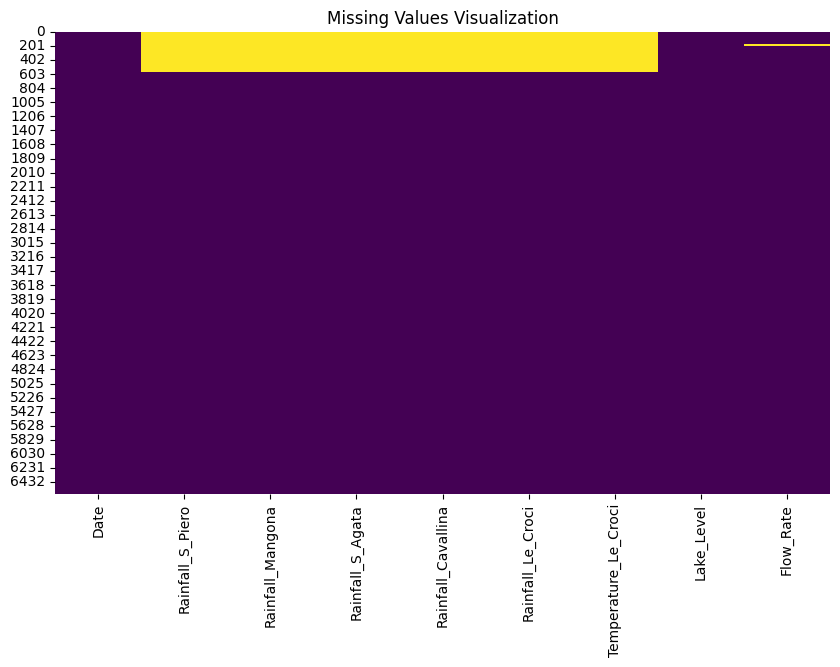

In [4]:
# 缺失值统计
missing_counts = df.isnull().sum()
print(missing_counts)

# 缺失值可视化
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Visualization')
plt.show()

In [5]:
# 删除包含空白数据的行
df_cleaned = df.dropna().reset_index(drop=True)

In [6]:
# 使用滑动窗口平滑数据，窗口大小设置为7
window_size = 7
df_smoothed = df_cleaned.copy()

# 对除 "Date" 列外的所有列应用滑动窗口平滑
for column in df_cleaned.columns[1:]:
    df_smoothed[column] = df_cleaned[column].rolling(window=window_size).mean()

# 剔除开始部分的NaN值（由于滑动窗口的效果）
df_smoothed = df_smoothed.dropna().reset_index(drop=True)

# 将"Date"列转换为日期格式
df_smoothed['Date'] = pd.to_datetime(df_smoothed['Date'], dayfirst=True)

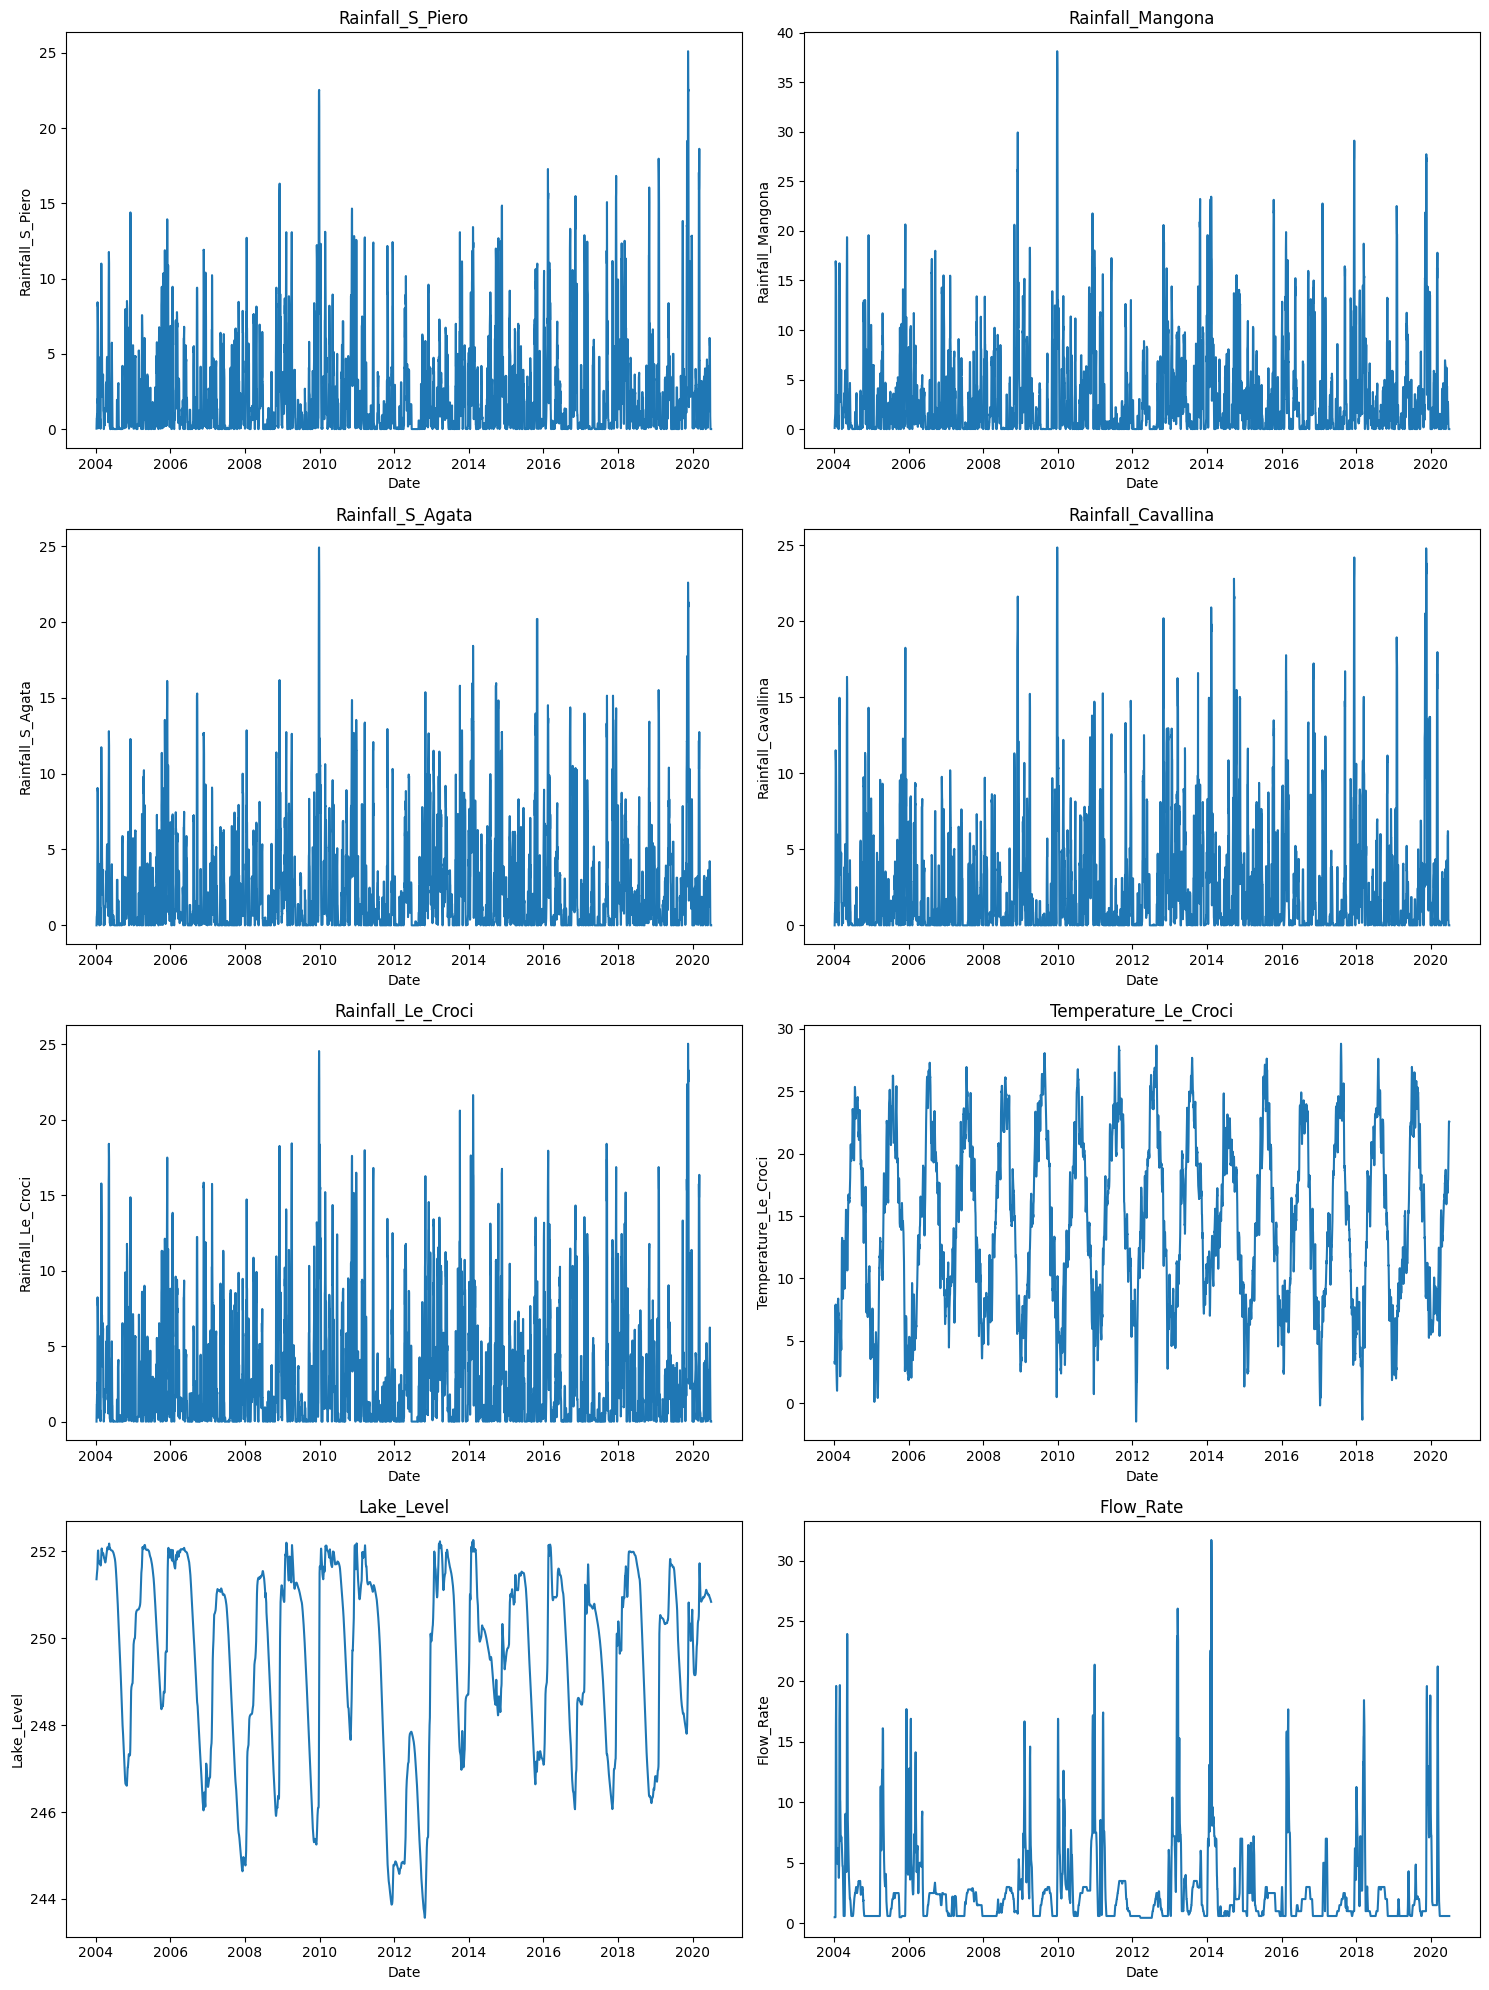

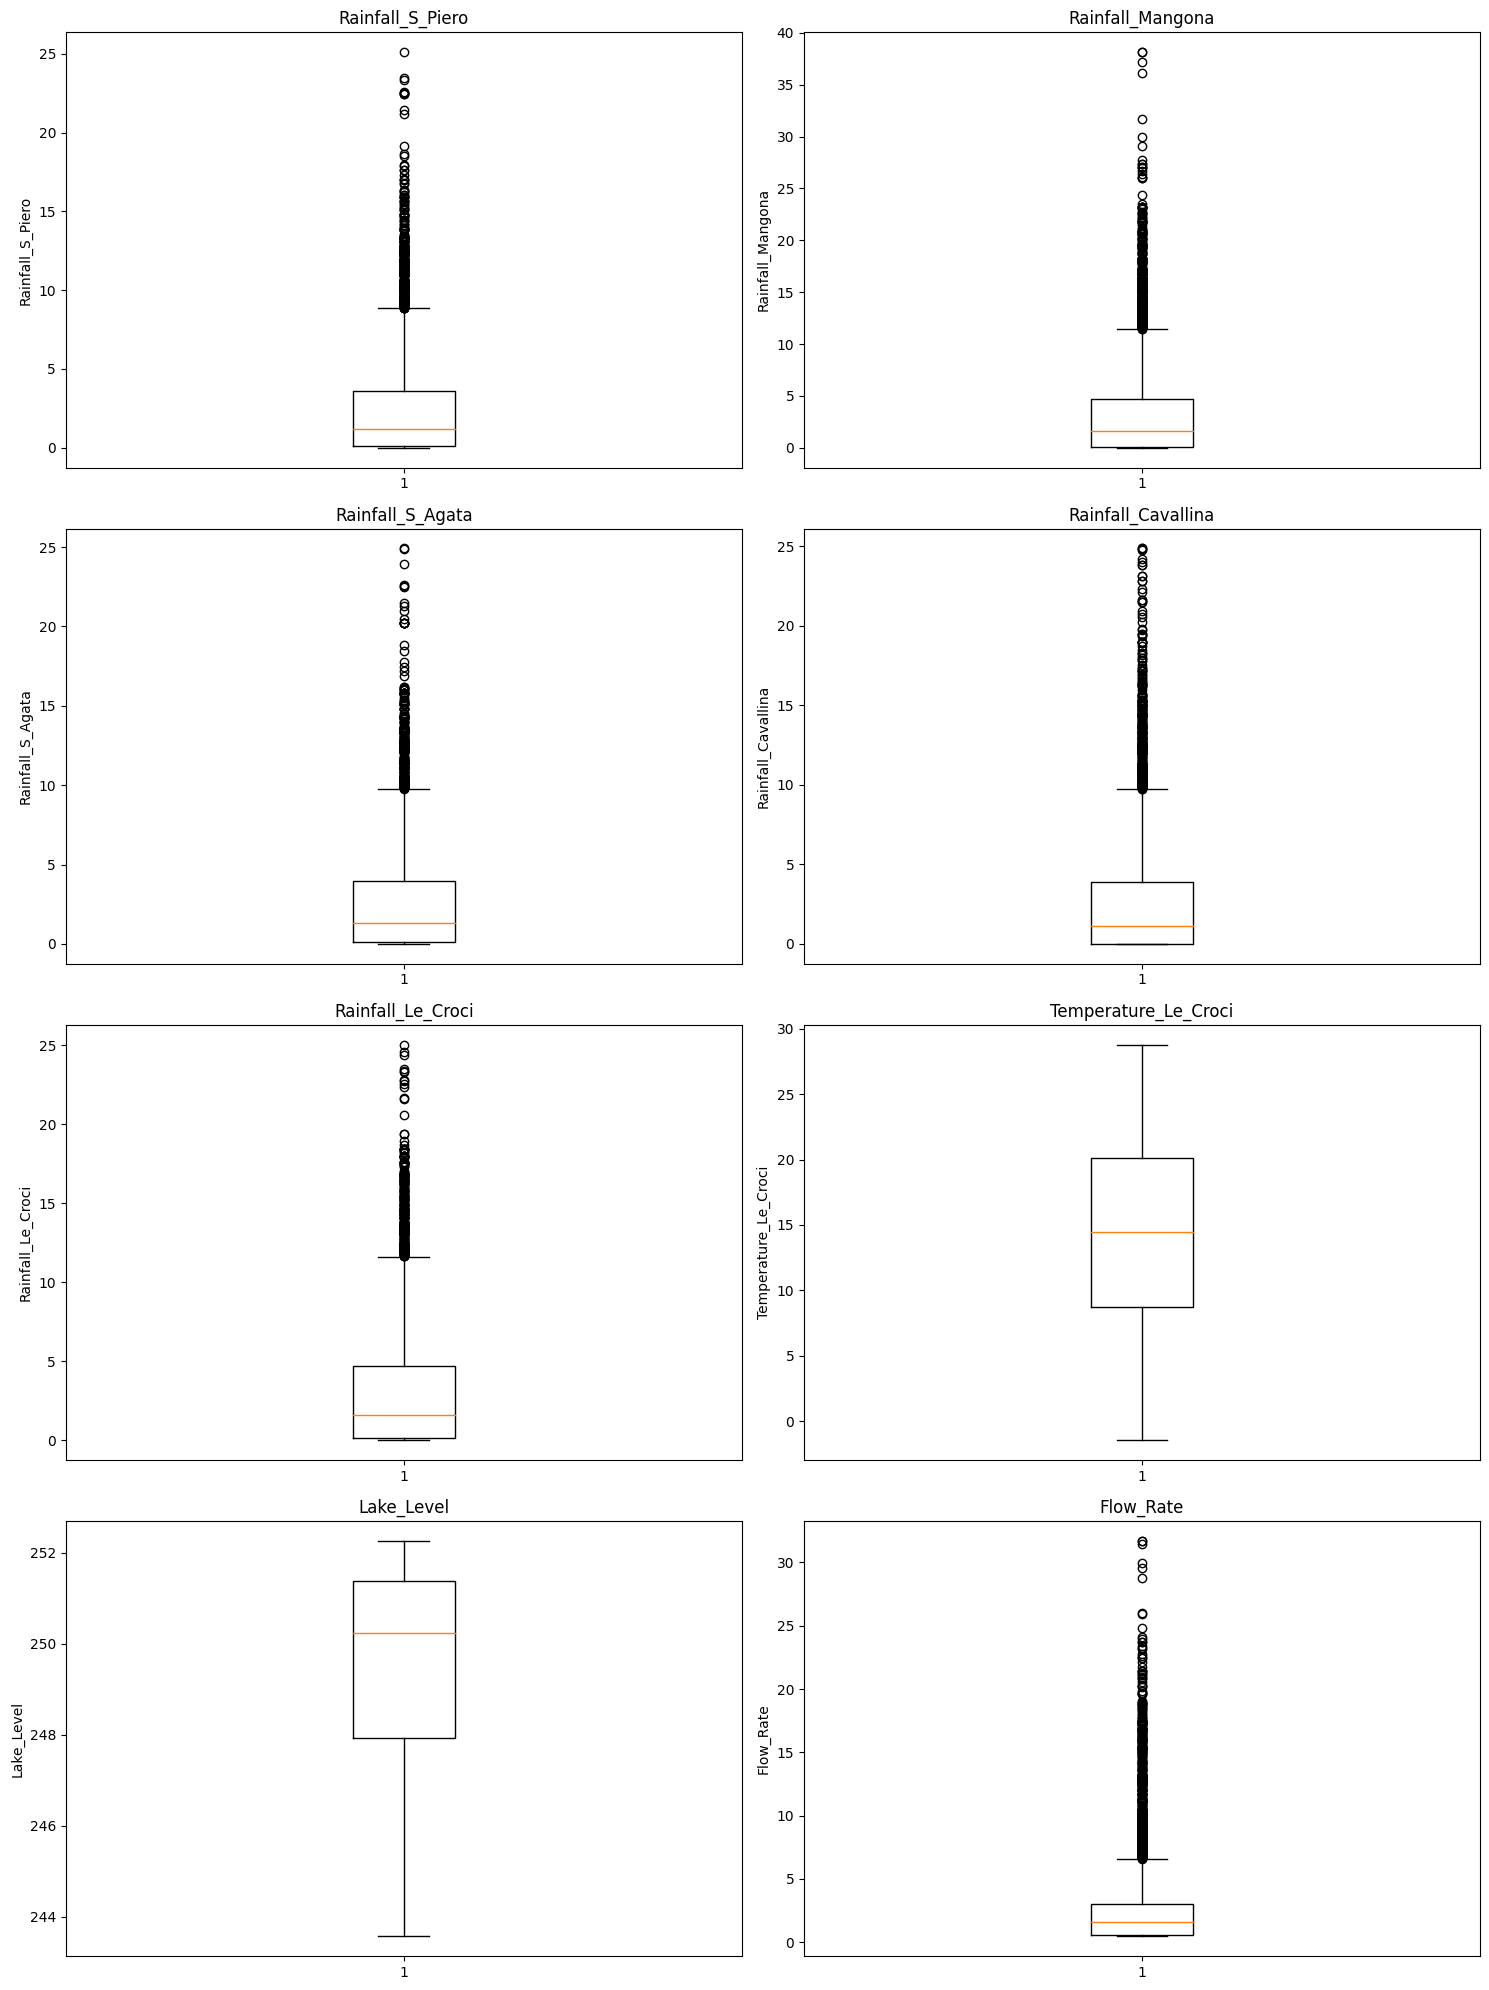

In [7]:
# 设置图的大小
plt.figure(figsize=(15, 20))
# 绘制每个数值变量随时间的变化
for i, column in enumerate(df_smoothed.columns[1:], 1):
    plt.subplot(4, 2, i)
    plt.plot(df_smoothed['Date'], df_smoothed[column])
    plt.title(column)
    plt.xlabel('Date')
    plt.ylabel(column)
plt.tight_layout()
plt.show()

# 设置图的大小
plt.figure(figsize=(15, 20))
# 绘制每个数值变量的箱线图
for i, column in enumerate(df_smoothed.columns[1:], 1):
    plt.subplot(4, 2, i)
    plt.boxplot(df_smoothed[column])
    plt.title(column)
    plt.ylabel(column)
plt.tight_layout()
plt.show()

processed_data_path = './dataset/Lake/processed_Lake_Bilancino.csv'
df_smoothed.to_csv(processed_data_path, index=False)

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Extracting the features and target variables
processed_data=pd.read_csv('./dataset/Lake/processed_Lake_Bilancino.csv')
features = processed_data.drop(['Date', 'Lake_Level', 'Flow_Rate'], axis=1)
target_lake_level = processed_data['Lake_Level']
target_flow_rate = processed_data['Flow_Rate']

# Scaling the features
scaler_features = MinMaxScaler()
scaled_features = scaler_features.fit_transform(features)

# Scaling the target variables
scaler_lake_level = MinMaxScaler()
lake_level_scaled = scaler_lake_level.fit_transform(target_lake_level.values.reshape(-1, 1))
flow_rate_scaled = scaler_lake_level.fit_transform(target_flow_rate.values.reshape(-1, 1))

# Function to create LSTM samples
def create_lstm_samples(data, label, window_size=7):
    X, Y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        Y.append(label[i+window_size])
    return np.array(X), np.array(Y)

# Creating LSTM samples for Lake_Level
X_lake_level, y_lake_level = create_lstm_samples(scaled_features, lake_level_scaled, window_size=7)
X_flow_rate, y_flow_rate = create_lstm_samples(scaled_features, flow_rate_scaled, window_size=7)

# Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(0.8 * len(X_lake_level))
X_train_lake, X_test_lake = X_lake_level[:train_size], X_lake_level[train_size:]
y_train_lake, y_test_lake = y_lake_level[:train_size], y_lake_level[train_size:]

X_train_flow, X_test_flow = X_flow_rate[:train_size], X_flow_rate[train_size:]
y_train_flow, y_test_flow = y_flow_rate[:train_size], y_flow_rate[train_size:]

X_train_lake.shape, X_train_flow.shape


c:\Users\zhouxiinlei\Anaconda3\envs\pytorch1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


((4809, 7, 6), (4809, 7, 6))

In [9]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch 
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.linear(out[:, -1, :]) 
        return out



In [10]:
# Hyperparameters
input_dim = 6
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 2000
learning_rate = 0.01

# Convert dataset into tensors
X_train_tensor_lake = torch.FloatTensor(X_train_lake)
y_train_tensor_lake = torch.FloatTensor(y_train_lake)

X_test_tensor_lake = torch.FloatTensor(X_test_lake)
y_test_tensor_lake = torch.FloatTensor(y_test_lake)

# Define the LSTM model, loss function and optimizer
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    outputs = model(X_train_tensor_lake)
    optimizer.zero_grad()
    
    # Obtain the loss function
    loss = criterion(outputs, y_train_tensor_lake)
    loss.backward()
    
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    
# Model evaluation on test data
model.eval()
test_outputs_lake = model(X_test_tensor_lake)
mse_loss = criterion(test_outputs_lake, y_test_tensor_lake)
print(f'MSE Loss on test data: {mse_loss.item()}')



Epoch 100/2000, Loss: 0.06829141080379486
Epoch 200/2000, Loss: 0.06541725248098373
Epoch 300/2000, Loss: 0.06182027608156204
Epoch 400/2000, Loss: 0.05859684199094772
Epoch 500/2000, Loss: 0.05495990440249443
Epoch 600/2000, Loss: 0.051476530730724335
Epoch 700/2000, Loss: 0.04732455685734749
Epoch 800/2000, Loss: 0.04168963059782982
Epoch 900/2000, Loss: 0.0353274904191494
Epoch 1000/2000, Loss: 0.030407465994358063
Epoch 1100/2000, Loss: 0.022389903664588928
Epoch 1200/2000, Loss: 0.01913951337337494
Epoch 1300/2000, Loss: 0.014635510742664337
Epoch 1400/2000, Loss: 0.02602078951895237
Epoch 1500/2000, Loss: 0.014561839401721954
Epoch 1600/2000, Loss: 0.011724937707185745
Epoch 1700/2000, Loss: 0.011604920960962772
Epoch 1800/2000, Loss: 0.009430479258298874
Epoch 1900/2000, Loss: 0.013628446497023106
Epoch 2000/2000, Loss: 0.006701215635985136
MSE Loss on test data: 0.0857829749584198


In [11]:
X_train_flow, X_test_flow = X_flow_rate[:train_size], X_flow_rate[train_size:]
y_train_flow, y_test_flow = y_flow_rate[:train_size], y_flow_rate[train_size:]

# Hyperparameters
input_dim = 6
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 2000
learning_rate = 0.01

# Convert dataset into tensors
X_train_tensor_flow = torch.FloatTensor(X_train_flow)
y_train_tensor_flow = torch.FloatTensor(y_train_flow)

X_test_tensor_flow = torch.FloatTensor(X_test_flow)
y_test_tensor_flow = torch.FloatTensor(y_test_flow)

# Define the LSTM model, loss function and optimizer
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    outputs = model(X_train_tensor_flow)
    optimizer.zero_grad()
    
    # Obtain the loss function
    loss = criterion(outputs, y_train_tensor_flow)
    loss.backward()
    
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    
# Model evaluation on test data
model.eval()
test_outputs_flow = model(X_test_tensor_flow)
mse_loss = criterion(test_outputs_flow, y_test_tensor_flow)
print(f'MSE Loss on test data: {mse_loss.item()}')

Epoch 100/2000, Loss: 0.008012445643544197
Epoch 200/2000, Loss: 0.0066846138797700405
Epoch 300/2000, Loss: 0.005514766089618206
Epoch 400/2000, Loss: 0.003939680755138397
Epoch 500/2000, Loss: 0.0037161775398999453
Epoch 600/2000, Loss: 0.002413578797131777
Epoch 700/2000, Loss: 0.0018999300664290786
Epoch 800/2000, Loss: 0.001513182302005589
Epoch 900/2000, Loss: 0.001302126212976873
Epoch 1000/2000, Loss: 0.0011782482033595443
Epoch 1100/2000, Loss: 0.0010251500643789768
Epoch 1200/2000, Loss: 0.0009610167471691966
Epoch 1300/2000, Loss: 0.0009256569319404662
Epoch 1400/2000, Loss: 0.0008431990281678736
Epoch 1500/2000, Loss: 0.0007092589512467384
Epoch 1600/2000, Loss: 0.0007289009517990053
Epoch 1700/2000, Loss: 0.0006238409550860524
Epoch 1800/2000, Loss: 0.0005905341822654009
Epoch 1900/2000, Loss: 0.0006096924771554768
Epoch 2000/2000, Loss: 0.0005354983732104301
MSE Loss on test data: 0.01266342494636774


In [12]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

In [13]:
# Hyperparameters
input_dim = 6 * 7  # 6 features for 7 days
output_dim = 1
learning_rate = 0.01
num_epochs = 2000

# Reshape data for linear regression (flatten the sequence dimension)
X_train_flat_lake = X_train_lake.reshape(X_train_lake.shape[0], -1)
X_test_flat_lake = X_test_lake.reshape(X_test_lake.shape[0], -1)

X_train_flat_flow = X_train_flow.reshape(X_train_flow.shape[0], -1)
X_test_flat_flow = X_test_flow.reshape(X_test_flow.shape[0], -1)

# Convert to tensors
X_train_tensor_flat_flow = torch.FloatTensor(X_train_flat_flow)
y_train_tensor_flow = torch.FloatTensor(y_train_flow)
X_test_tensor_flat_flow = torch.FloatTensor(X_test_flat_flow)
y_test_tensor_flow = torch.FloatTensor(y_test_flow)

# Define the model, loss, and optimizer
linear_model = LinearRegressionModel(input_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(linear_model.parameters(), lr=learning_rate)

# Training loop for Flow_Rate
for epoch in range(num_epochs):
    outputs = linear_model(X_train_tensor_flat_flow)
    optimizer.zero_grad()

    # Compute the loss
    loss = criterion(outputs, y_train_tensor_flow)
    loss.backward()

    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# Evaluate the model on test data
linear_model.eval()
test_outputs = linear_model(X_test_tensor_flat_flow)
mse_loss = criterion(test_outputs, y_test_tensor_flow)
print(f'MSE Loss on test data for Flow_Rate using Linear Regression: {mse_loss.item()}')


Epoch 100/2000, Loss: 0.009478379972279072
Epoch 200/2000, Loss: 0.009171418845653534
Epoch 300/2000, Loss: 0.009091237559914589
Epoch 400/2000, Loss: 0.009049193002283573
Epoch 500/2000, Loss: 0.009019503369927406
Epoch 600/2000, Loss: 0.0089966906234622
Epoch 700/2000, Loss: 0.008978398516774178
Epoch 800/2000, Loss: 0.00896330364048481
Epoch 900/2000, Loss: 0.008950598537921906
Epoch 1000/2000, Loss: 0.00893977377563715
Epoch 1100/2000, Loss: 0.008930500596761703
Epoch 1200/2000, Loss: 0.008922558277845383
Epoch 1300/2000, Loss: 0.008915775455534458
Epoch 1400/2000, Loss: 0.008910004049539566
Epoch 1500/2000, Loss: 0.008905106224119663
Epoch 1600/2000, Loss: 0.008900952525436878
Epoch 1700/2000, Loss: 0.008897420950233936
Epoch 1800/2000, Loss: 0.008894404396414757
Epoch 1900/2000, Loss: 0.008891805075109005
Epoch 2000/2000, Loss: 0.008889545686542988
MSE Loss on test data for Flow_Rate using Linear Regression: 0.009273638017475605


In [14]:
# Convert Lake_Level data to tensors
X_train_tensor_flat_lake = torch.FloatTensor(X_train_flat_lake)
y_train_tensor_lake = torch.FloatTensor(y_train_lake)
X_test_tensor_flat_lake = torch.FloatTensor(X_test_flat_lake)
y_test_tensor_lake = torch.FloatTensor(y_test_lake)

# Re-define the model, loss, and optimizer for Lake_Level
# (Or you can use the same model and reinitialize its weights)
linear_model_lake = LinearRegressionModel(input_dim, output_dim)
optimizer_lake = torch.optim.Adam(linear_model_lake.parameters(), lr=learning_rate)

# Training loop for Lake_Level
for epoch in range(num_epochs):
    outputs_lake = linear_model_lake(X_train_tensor_flat_lake)
    optimizer_lake.zero_grad()

    # Compute the loss
    loss_lake = criterion(outputs_lake, y_train_tensor_lake)
    loss_lake.backward()

    optimizer_lake.step()

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss for Lake_Level: {loss_lake.item()}")

# Evaluate the model on test data for Lake_Level
linear_model_lake.eval()
test_outputs_lake = linear_model_lake(X_test_tensor_flat_lake)
mse_loss_lake = criterion(test_outputs_lake, y_test_tensor_lake)
print(f'MSE Loss on test data for Lake_Level using Linear Regression: {mse_loss_lake.item()}')


Epoch 100/2000, Loss for Lake_Level: 0.07298702746629715
Epoch 200/2000, Loss for Lake_Level: 0.06716342270374298
Epoch 300/2000, Loss for Lake_Level: 0.0662713497877121
Epoch 400/2000, Loss for Lake_Level: 0.06580941379070282
Epoch 500/2000, Loss for Lake_Level: 0.06551788002252579
Epoch 600/2000, Loss for Lake_Level: 0.06534721702337265
Epoch 700/2000, Loss for Lake_Level: 0.06525271385908127
Epoch 800/2000, Loss for Lake_Level: 0.06520061194896698
Epoch 900/2000, Loss for Lake_Level: 0.06516970694065094
Epoch 1000/2000, Loss for Lake_Level: 0.06514843553304672
Epoch 1100/2000, Loss for Lake_Level: 0.06513120234012604
Epoch 1200/2000, Loss for Lake_Level: 0.0651155635714531
Epoch 1300/2000, Loss for Lake_Level: 0.06510056555271149
Epoch 1400/2000, Loss for Lake_Level: 0.06508580595254898
Epoch 1500/2000, Loss for Lake_Level: 0.06507115811109543
Epoch 1600/2000, Loss for Lake_Level: 0.06505651772022247
Epoch 1700/2000, Loss for Lake_Level: 0.06504186242818832
Epoch 1800/2000, Loss for

In [15]:
lstm_predictions = test_outputs_flow.detach().numpy()
linear_predictions = linear_model(X_test_tensor_flat_flow).detach().numpy()
true_values = y_test_tensor_flow.detach().numpy()

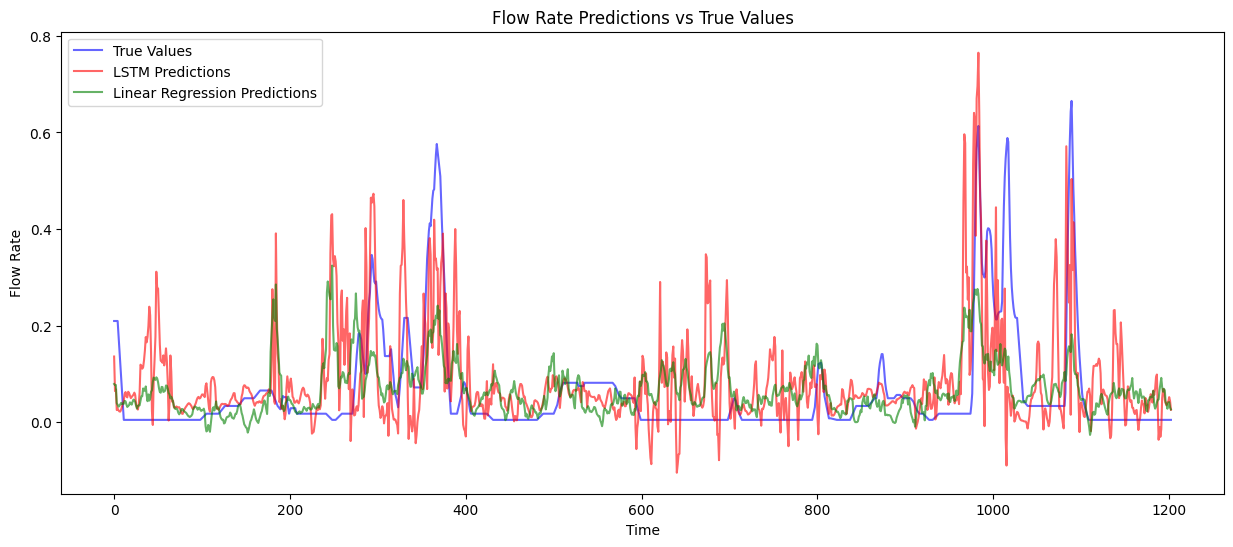

In [16]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(15, 6))

# Plot the true values
plt.plot(true_values, label='True Values', color='blue', alpha=0.6)

# Plot the predictions from LSTM
plt.plot(lstm_predictions, label='LSTM Predictions', color='red', alpha=0.6)

# Plot the predictions from Linear Regression
plt.plot(linear_predictions, label='Linear Regression Predictions', color='green', alpha=0.6)

# Set the title and labels
plt.title('Flow Rate Predictions vs True Values')
plt.xlabel('Time')
plt.ylabel('Flow Rate')
plt.legend()

# Show the plot
plt.show()


In [18]:
lstm_predictions_lake = test_outputs_lake.detach().numpy()  # Replace with your LSTM predictions for Lake_Level
linear_predictions_lake = linear_model(X_test_tensor_flat_lake).detach().numpy()  # Replace with your linear regression predictions for Lake_Level
true_values_lake = y_test_tensor_lake.detach().numpy()


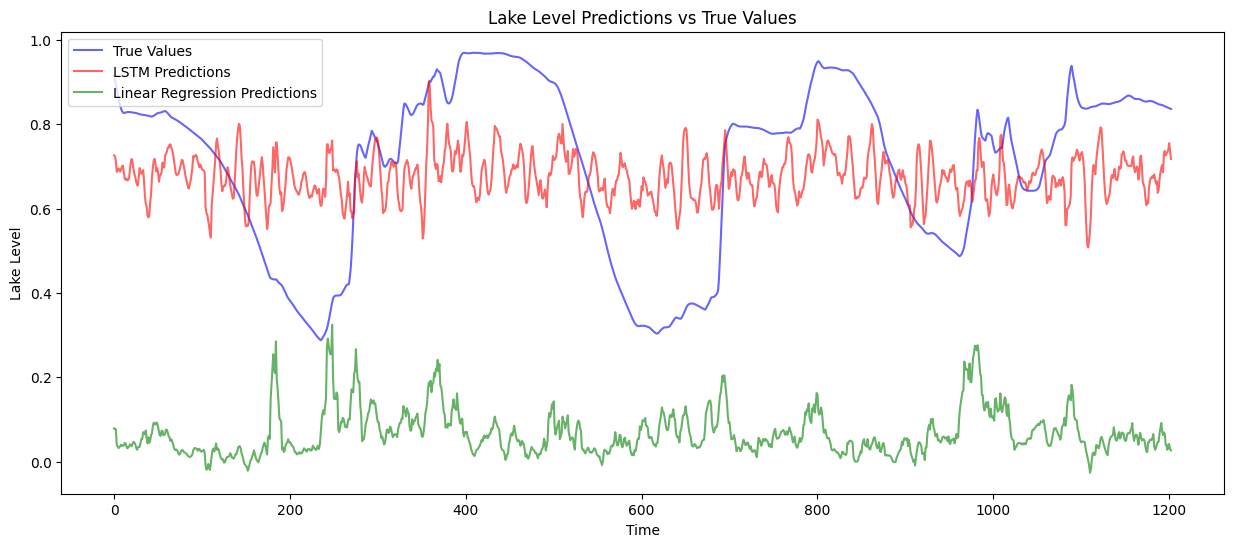

In [19]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(15, 6))

# Plot the true values
plt.plot(true_values_lake, label='True Values', color='blue', alpha=0.6)

# Plot the predictions from LSTM
plt.plot(lstm_predictions_lake, label='LSTM Predictions', color='red', alpha=0.6)

# Plot the predictions from Linear Regression
plt.plot(linear_predictions_lake, label='Linear Regression Predictions', color='green', alpha=0.6)

# Set the title and labels
plt.title('Lake Level Predictions vs True Values')
plt.xlabel('Time')
plt.ylabel('Lake Level')
plt.legend()

# Show the plot
plt.show()
